In [1]:
import sympy as sm

Manipulating the norm into an usable equation:

In [2]:
#Working with their LHS of Eq 2:
t = sm.symbols('t')
x = sm.Function('x')(t)
y = sm.Function('y')(t)

#Create State Vector
X = sm.Matrix([x, y])

#Create EQ 2 LHS:
b = sm.symbols('b')
LHS = X.diff('t','t') + b*X.diff('t') + X
LHS

Matrix([
[b*Derivative(x(t), t) + x(t) + Derivative(x(t), (t, 2))],
[b*Derivative(y(t), t) + y(t) + Derivative(y(t), (t, 2))]])

In [3]:
#Now, create the RHS for a given x_n and y_n of a magnet
p_n, x_n, y_n, h = sm.symbols('p_n, x_n, y_n, h')
X_n = sm.Matrix([x_n, y_n])

RHS_gen = p_n * (X_n - X)/((X_n-X).norm()**2 + h**2)**(5/2)
RHS_gen

Matrix([
[p_n*(x_n - x(t))/(h**2 + Abs(x_n - x(t))**2 + Abs(y_n - y(t))**2)**2.5],
[p_n*(y_n - y(t))/(h**2 + Abs(x_n - x(t))**2 + Abs(y_n - y(t))**2)**2.5]])

In [4]:
# Now we combine these two halves, and substitue the RHS for magnet locations on the unit circle.
X_1 = [1, 1]; X_2 = [1, -1]; X_3 = [-1, -1]; X_4 = [-1, 1]
p = 1
EQ_2 = sm.Eq(LHS,
             RHS_gen.subs({x_n: X_1[0], y_n: X_1[1], p_n: p}) +
             RHS_gen.subs({x_n: X_2[0], y_n: X_2[1], p_n: p}) +
             RHS_gen.subs({x_n: X_3[0], y_n: X_3[1], p_n: p}) +
             RHS_gen.subs({x_n: X_4[0], y_n: X_4[1], p_n: p})
            )
EQ_2.simplify()

Eq(Matrix([
[b*Derivative(x(t), t) + x(t) + Derivative(x(t), (t, 2))],
[b*Derivative(y(t), t) + y(t) + Derivative(y(t), (t, 2))]]), Matrix([
[-(x(t) - 1)/(h**2 + Abs(x(t) - 1)**2 + Abs(y(t) - 1)**2)**2.5 - (x(t) - 1)/(h**2 + Abs(x(t) - 1)**2 + Abs(y(t) + 1)**2)**2.5 - (x(t) + 1)/(h**2 + Abs(x(t) + 1)**2 + Abs(y(t) - 1)**2)**2.5 - (x(t) + 1)/(h**2 + Abs(x(t) + 1)**2 + Abs(y(t) + 1)**2)**2.5],
[-(y(t) - 1)/(h**2 + Abs(x(t) - 1)**2 + Abs(y(t) - 1)**2)**2.5 - (y(t) - 1)/(h**2 + Abs(x(t) + 1)**2 + Abs(y(t) - 1)**2)**2.5 - (y(t) + 1)/(h**2 + Abs(x(t) - 1)**2 + Abs(y(t) + 1)**2)**2.5 - (y(t) + 1)/(h**2 + Abs(x(t) + 1)**2 + Abs(y(t) + 1)**2)**2.5]]))

So with this we have four states:

$\left[\matrix{x \\ \dot x \\ y \\ \dot y}\right] = \left[\matrix{z_1 \\ z_2 \\ z_3 \\ z_4}\right]$

We can rearrange our equation that we got from SymPy into two first order differential equations:

$$\left[\matrix{\dot z_1 \\ \dot z_2 \\ \dot z_3 \\ \dot z_4} \right] = 
\left[\matrix{
z_2 \\
-\frac{z_1 - 1}{\left(h^2+(z_1-1)^2 + (z_3 - 1)^2 \right)^{2.5}} 
    -\frac{z_1 - 1}{\left(h^2+(z_1-1)^2 + (z_3 + 1)^2 \right)^{2.5}} 
    -\frac{z_1 + 1}{\left(h^2+(z_1+1)^2 + (z_3 - 1)^2 \right)^{2.5}} 
    -\frac{z_1 + 1}{\left(h^2+(z_1+1)^2 + (z_3 + 1)^2 \right)^{2.5}} 
    - b z_2 - z_1 \\
z_4 \\
-\frac{z_3 - 1}{\left(h^2+(z_1-1)^2 + (z_3 - 1)^2 \right)^{2.5}} 
    -\frac{z_3 - 1}{\left(h^2+(z_1+1)^2 + (z_3 - 1)^2 \right)^{2.5}} 
    -\frac{z_3 + 1}{\left(h^2+(z_1-1)^2 + (z_3 + 1)^2 \right)^{2.5}} 
    -\frac{z_3 + 1}{\left(h^2+(z_1+1)^2 + (z_3 + 1)^2 \right)^{2.5}} 
    - b z_4 - z_3\\
}\right]$$

and this we can use with SciPy's odeint.

Let's do it:

In [103]:
import numpy as np
from scipy.integrate import odeint
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm
from numba import jit

''' 
Code below is heavily borrowed from Nikhil Bajaj, University of Pittsburgh from ME2016 Nonlinear Dynamics 1.

Major Changes:
Oscilator was changed into the magnetic pendulum. 4 states instead of 2

'''
# Declare Global Variables
h = 0.5
b_global = 0.175

# Accelerate the ODE system using numba
@jit(nopython=True)
def magnetic_pendulum(Z, t):
    z_1, z_2, z_3, z_4, b = Z #z_1 = x, z_2 = x_dot, z_3 = y, z_4 = y_dot, z_5 = b (for convenience to change damping)
    dz_1dt = z_2  
    dz_2dt = -(z_1 - 1)/(h**2 + (z_1 - 1)**2 + (z_3 - 1)**2)**2.5 \
                - (z_1 - 1)/(h**2 + (z_1 - 1)**2 + (z_3 + 1)**2)**2.5 \
                - (z_1 + 1)/(h**2 + (z_1 + 1)**2 + (z_3 - 1)**2)**2.5 \
                - (z_1 + 1)/(h**2 + (z_1 + 1)**2 + (z_3 + 1)**2)**2.5 \
                - b*z_2 - z_1
    dz_3dt = z_4  
    dz_4dt = -(z_3 - 1)/(h**2 + (z_1 - 1)**2 + (z_3 - 1)**2)**2.5 \
                - (z_3 - 1)/(h**2 + (z_1 + 1)**2 + (z_3 - 1)**2)**2.5 \
                - (z_3 + 1)/(h**2 + (z_1 - 1)**2 + (z_3 + 1)**2)**2.5 \
                - (z_3 + 1)/(h**2 + (z_1 + 1)**2 + (z_3 + 1)**2)**2.5 \
                - b*z_4 - z_3
    db_dt = 0
    return [dz_1dt, dz_2dt, dz_3dt, dz_4dt, db_dt]

# Function to simulate a batch of initial conditions
def simulate_batch(batch):
    t = np.linspace(0, 1000, 500)  # Larger time steps for benchmarking
    results = [(t, odeint(magnetic_pendulum, ic, t)) for ic in batch]
    return results

# Function to run simulations using joblib for parallelism
def parallel_simulations(initial_conditions_list, batch_size=2):
    # Split the initial conditions into batches to reduce overhead
    batches = [
        initial_conditions_list[i:i + batch_size]
        for i in range(0, len(initial_conditions_list), batch_size)
    ]
    
    # Run parallel simulations with joblib
    results = Parallel(n_jobs=-1)(
        delayed(simulate_batch)(batch) for batch in tqdm(batches, desc="Running Simulations")
    )
    
    # Flatten the list of batches into a single list of results
    return [item for batch_result in results for item in batch_result]

# Benchmarking function
def benchmark(initial_conditions_list):
    print("Benchmarking...")

    # Single-process execution
    #start_time = time.time()
    #single_process_results = [simulate_batch([ic])[0] for ic in initial_conditions_list]
    #single_process_time = time.time() - start_time
    #print(f"Single-process execution time: {single_process_time:.2f} seconds")

    # Parallel execution with joblib
    start_time = time.time()
    parallel_results = parallel_simulations(initial_conditions_list, batch_size=2)
    parallel_time = time.time() - start_time
    print(f"Parallel execution time: {parallel_time:.2f} seconds")

    return None, parallel_results

# List of initial conditions for benchmarking
num_pixels = 50
nudge = 1e-1
value_range = np.linspace(-2+nudge, 2+nudge, num_pixels)
zeros = np.zeros([num_pixels**2])
b_vec = np.ones([num_pixels**2])*b_global
x_values, y_values = np.meshgrid(value_range, value_range)

initial_conditions_list = np.column_stack((x_values.flatten(), zeros, y_values.flatten(), zeros, b_vec))
#initial_conditions_list
#plt.plot(x_values,y_values, 'x')

In [104]:
# Run the benchmark
single_process_results, parallel_results = benchmark(initial_conditions_list)

Benchmarking...


Running Simulations:   0%|          | 0/1250 [00:00<?, ?it/s]

Parallel execution time: 28.63 seconds


In [101]:
# Figure Out Final Magnets
final_magnet = np.zeros([num_pixels**2,3])
smallest_distance = np.zeros(num_pixels**2)

for i, (t, solution) in enumerate(parallel_results):
    last_location = np.asarray([solution[-1,0], solution[-1,2]])
    
    dist = np.asarray([np.linalg.norm(X_1-last_location), 
            np.linalg.norm(X_2-last_location),
            np.linalg.norm(X_3-last_location),
            np.linalg.norm(X_4-last_location)])
    final_magnet[i,:] = np.asarray([solution[0,0], solution[0,2], np.argmin(dist)])
    smallest_distance[i] = np.min(dist)


(array([[-1.9       , -1.9       ,  0.        ],
        [-1.81836735, -1.9       ,  1.        ],
        [-1.73673469, -1.9       ,  2.        ],
        ...,
        [ 1.93673469,  2.1       ,  1.        ],
        [ 2.01836735,  2.1       ,  2.        ],
        [ 2.1       ,  2.1       ,  2.        ]]),
 array([0.0467005 , 0.0467005 , 0.0467005 , ..., 0.0467005 , 1.41421356,
        1.41421356]))

In [132]:
magnet_map = np.zeros([num_pixels**2, 3])
for i, magnet in enumerate(final_magnet[:,2]):
    if magnet == 0:
        magnet_map[i,:] = [1.0, 0, 0]
    elif magnet == 1:
        magnet_map[i,:] = [0, 1.0, 0]
    elif magnet == 2:
        magnet_map[i,:] = [0, 0, 1.0]
    elif magnet == 3:
        magnet_map[i,:] = [1.0, 1.0, 0]
    else:
        print('dear god')

magnet_map = magnet_map.reshape([num_pixels, num_pixels, 3])        

Text(0.5, 0.98, 'Basin of Attraction with b = 0.175.')

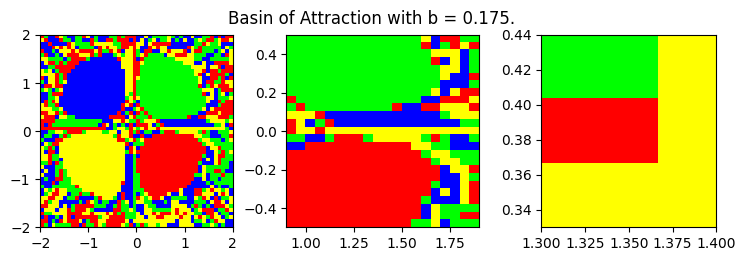

In [151]:
fig, axs = plt.subplots(1, 3, figsize = (9, 10/4))

axs[0].imshow(magnet_map, extent = [-2, 2, -2, 2])
axs[1].imshow(magnet_map[int(num_pixels*0.5/2):int(num_pixels*1.5/2), int(num_pixels*1.1/2):int(num_pixels*1.9/2), :], extent = [0.9, 1.9, -0.5, 0.5])
axs[2].imshow(magnet_map[int(num_pixels*1.83/2):int(num_pixels*1.93/2), int(num_pixels*1.3/2):int(num_pixels*1.4/2), :], extent = [1.3, 1.4, 0.33, 0.44])
fig.suptitle(f'Basin of Attraction with b = {b_global:.3f}.')

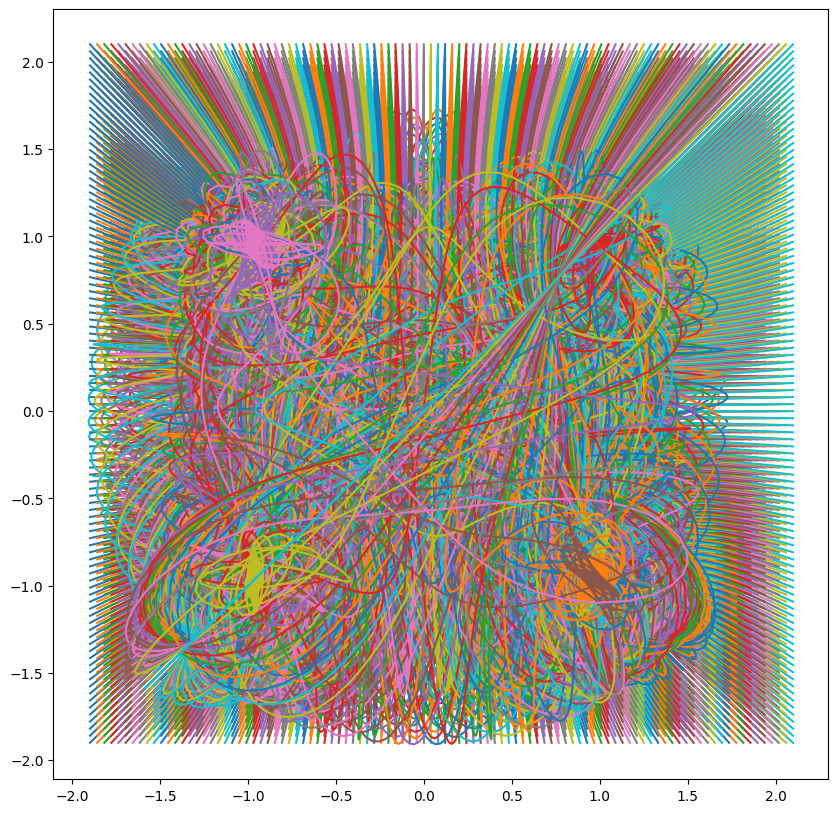

In [66]:
# Plotting all results on the same plot (using the parallel results)
plt.figure(figsize=(10, 10))
for i, (t, solution) in enumerate(parallel_results):
    #print(solution[:10,:])
    plt.plot(solution[:,0], solution[:, 2], label=f'Initial Condition {i+1}')